# Convolutional neural networks

## Introduction

<b>Convolution</b> is defined as:

$$ (f_1 \ast f_2)(t) = \int_{-\infty}^{\infty} f_1(\tau)f_2(t - \tau)d\tau $$

**discrete convolution** is given by:


$$ (f_1 \ast f_2)[n] = \sum_{m = -\infty}^{\infty} f_1[m]f_2[n - m] $$


Convolution is:

- <b>commutative:</b> $$f_1 \ast f_2 = f_2 \ast f_1 $$

- <b>associative:</b> $$(f_1 \ast f_2)\ast f_3 = f_1 \ast (f_2 \ast f_3)$$

- <b>distributive:</b> $$ (f_1 + f_2) \ast f_3 = f_1 \ast f_3 + f_2 \ast f_3$$

Convolution is a product of one function modified by the other. Intuitively, it is somewhat similar to the weighted average - at each point, values of some function are scaled by the other function at surroundings of that point and then aggregated:

[![matrix convolution](https://ujwlkarn.files.wordpress.com/2016/07/convolution_schematic.gif?w=268&h=196&zoom=2)](https://ujwlkarn.files.wordpress.com/2016/07/convolution_schematic.gif?w=268&h=196&zoom=2)

Code example:

In [1]:
input = [1 1 1 0 0; 0 1 1 1 0; 0 0 1 1 1; 0 0 1 1 0; 0 1 1 0 0]
filter = [1 0 1; 0 1 0; 1 0 1]

3×3 Matrix{Int64}:
 1  0  1
 0  1  0
 1  0  1

In [2]:
function convolution(input, filter)
    n_in, m_in = size(input)
    n_f, m_f = size(filter)
    conv = zeros(n_in - n_f + 1, m_in - m_f + 1)
    for (i,j) in Tuple.(CartesianIndices(conv))
        conv[i,j] = sum(input[i:i+n_f-1,j:j+m_f-1].*filter)
    end
    conv
end

convolution (generic function with 1 method)

In [3]:
convolution(input, filter)

3×3 Matrix{Float64}:
 4.0  3.0  4.0
 2.0  4.0  3.0
 2.0  3.0  4.0

### Cross-correlation, Autocorrelation 

<b>Cross-correlation</b> is a measure related to the convolution and is often used in a similar context. Cross-correlation measures the similarity of two functions as a function of the displacement $\Delta t$:
$$ (f_1 \star f_2)(\Delta t) = \int_{-\infty}^{\infty} f_1(t)f_2(t + \Delta t)d \Delta t $$

and for the discrete cases:


$$ (f_1 \star f_2)[n] = \sum_{m = -\infty}^{\infty} f_1[m]f_2[n + m] $$

<b>Autocorrelation</b> is a special case of the cross-correlation.


[![splot macierzy](https://upload.wikimedia.org/wikipedia/commons/2/21/Comparison_convolution_correlation.svg)](https://en.wikipedia.org/wiki/Cross-correlatxv>20)

### Examples


- Weighted moving average:

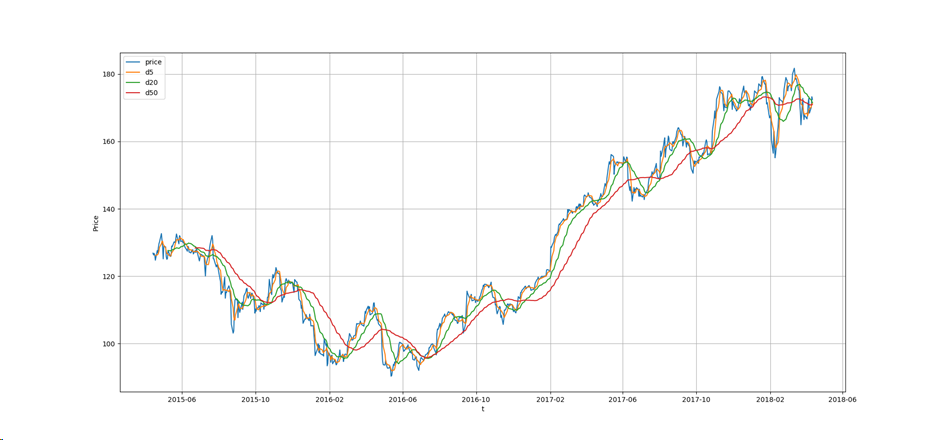

- kernel density estimation:

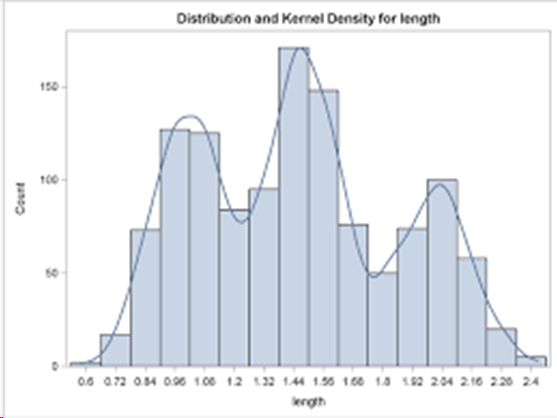

- signal modulation (e.g. reverb and echo):

In [4]:
using WAV, DSP

In [5]:
isfile("count-30-to-0.wav") ||
  download("https://github.com/bartoszpankratz/221660-0553-Aproksymacja/blob/master/3.%20Sieci%20konwolucyjne/count-30-to-0.wav?raw=true","count-30-to-0.wav")

true

In [6]:
x, f = wavread("count-30-to-0.wav");
x = vec(x);

In [7]:
#wavplay(x, f);

In [8]:
output = DSP.conv(x, x./100);

In [9]:
wavwrite(output, f, "audio_filtering_original_smoothed.wav");
#wavplay(output, f);

- image processing  (e.g. blur or edge detection):

In [10]:
using Images, TestImages

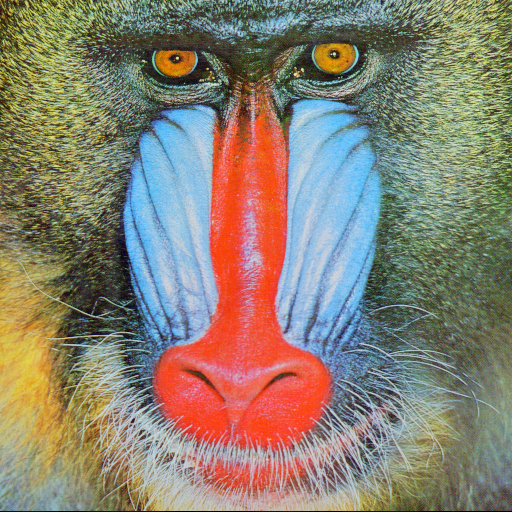

In [11]:
img = testimage("mandrill")
img

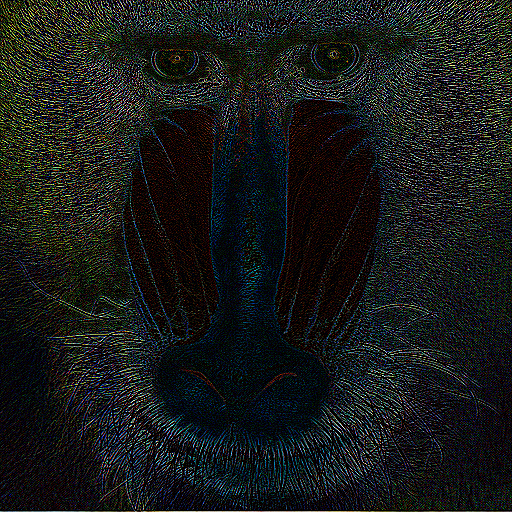

In [12]:
imfilter(img, Kernel.Laplacian())

## Convolutional Neural Network (CNN)

[![](https://res.mdpi.com/entropy/entropy-19-00242/article_deploy/html/images/entropy-19-00242-g001.png)](https://towardsdatascience.com/how-to-teach-a-computer-to-see-with-convolutional-neural-networks-96c120827cd1)

CNNs contains three successive stages:

#### Convolution

The first step of a convolutional layer is a convolution itself. Data processing, image processing in particular, is based on the [small filters](https://en.wikipedia.org/wiki/Kernel_%28image_processing%29). (**kernels** or **masks**) used to extract or strengthen specific properties of the object. These filters are convolved with a baseline object, giving us the processed result. However, filters must be chosen beforehand; it means that we introduce some form of bias in the data processing step. What if we allow a model to choose proper kernels on its own? 

This is the core property of CNNs. Instead of the predefined kernels such networks use **feature maps** - kernels that are randomly initialized and optimized during the training.

In [13]:
#code based on the: https://github.com/FluxML/Flux.jl/blob/master/src/layers/conv.jl#L183
using Flux

function conv_filter(filter::NTuple{N,Integer}, ch::Pair{<:Integer,<:Integer};
          init = Flux.glorot_uniform) where N
  cin, cout = ch
  init(filter..., cin, cout)
end

conv_filter (generic function with 1 method)

In [14]:
filters = conv_filter((3,3), 1 => 3)

3×3×1×3 Array{Float32, 4}:
[:, :, 1, 1] =
  0.370278   -0.150878    0.196184
 -0.0162907   0.245866   -0.202871
 -0.140482   -0.0750483  -0.39939

[:, :, 1, 2] =
 -0.0192319  -0.227901   0.294483
  0.35885     0.39656   -0.359287
  0.404899   -0.279896  -0.294272

[:, :, 1, 3] =
 -0.349596   0.401829  -0.27253
 -0.247688  -0.328149  -0.193588
 -0.221597   0.107705   0.192805

In [15]:
test_img = Float32.(Gray.(img));

In [16]:
conv_image = cat([convolution(test_img,filters[:,:,1,i]) for i = 1:size(filters)[end]]..., dims = 4);

#### Detector stage

By definition, convolution is a linear operation. To improve the predictive power of a network we want to introduce nonlinearity to the model. We achieve that by inputting each data point (e.g. one pixel) into a nonlinear activation function (e.g. ReLU).

In [17]:
detector_image = Flux.relu.(conv_image);

#### Pooling

**Pooling** is the final step of a convolutional layer. We could think about it as a "trimming" of the output data:

[![](https://shafeentejani.github.io/assets/images/pooling.gif)](https://towardsdatascience.com/how-to-teach-a-computer-to-see-with-convolutional-neural-networks-96c120827cd1)

Pooling is necessary for the following reasons:
- It reduces the size of the data, simplifying the problem and allowing us to build deeper and less computationally expensive models.
- It is a form of regularization.
- Pooling exploits the stationarity of the objects - it will detect given property in all parts of the picture.
- Because of pooling, the approximation is invariant to local translation.

Most common types of pooling:
- <b>max-pooling</b>
- <b>min-pooling</b>
- <b>mean-pooling</b>

In [18]:
function max_pool(input, kernel_size::Tuple{Int,Int}, stride = kernel_size)
    pooled_input = zeros(Int.((size(input) .-kernel_size) .÷ stride .+ 1))
    for (i,j) in Tuple.(CartesianIndices(pooled_input))
        k = (i-1) * kernel_size[1] .+ 1
        l = (j-1) * kernel_size[2] .+ 1
        pooled_input[i,j] = maximum(input[k:k+kernel_size[1]-1,l:l+kernel_size[2]-1])
    end
    pooled_input
end
   

max_pool (generic function with 2 methods)

In [19]:
pooled_image = cat([max_pool(detector_image[:,:,1,i], (5,5)) for i = 1:size(detector_image)[end]]..., dims = 4);

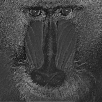

In [20]:
Gray.(pooled_image[:,:,1,2])

## Example

Firstly, we will prepare [data](https://github.com/zalandoresearch/fashion-mnist):

In [21]:
using Flux, ParameterSchedulers, Optimisers, Statistics, CUDA 
using Base.Iterators: repeated, partition
using Printf, BSON, JLD2, LinearAlgebra
using ImageCore, Images
using MLDatasets: convert2image, FashionMNIST

In [22]:
train_set = FashionMNIST(:train)

dataset FashionMNIST:
  metadata  =>    Dict{String, Any} with 4 entries
  split     =>    :train
  features  =>    28×28×60000 Array{Float32, 3}
  targets   =>    60000-element Vector{Int64}

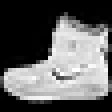

In [23]:
convert2image(FashionMNIST, train_set.features)[:,:,1]

In [24]:
use_cuda = true

true

In [25]:
 if use_cuda && CUDA.functional()
    device = gpu
    @info "Training on GPU"
else
    device = cpu
    @info "Training on CPU"
end

[ Info: Training on CPU


In [26]:
epochs = 150;
batch_size = 64;

Function that splits dataset into batches of size <tt>batch_size</tt>:

In [27]:
function make_minibatch(X, Y, idxs)
    X_batch = Array{Float32}(undef, size(X)[1], size(X)[2], 1, length(idxs))
    for i in 1:length(idxs)
        X_batch[:, :, 1, i] = Float32.(X[:, :, idxs[i]])
    end
    Y_batch = Flux.onehotbatch(Y[idxs], 0:9)
    return (X_batch, Y_batch)
end


make_minibatch (generic function with 1 method)

Let us divide the dataset:

In [28]:
mb_idxs = partition(1:size(train_set.features)[3], batch_size)
train_set = [make_minibatch(train_set.features, train_set.targets, i) for i in mb_idxs] |> device

938-element Vector{Tuple{Array{Float32, 4}, OneHotArrays.OneHotMatrix{UInt32, Vector{UInt32}}}}:
 ([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; … ;;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0 1 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 1 0 … 0 0])
 ([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; … ;;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 0.0 0

The same for the test set:

In [29]:
test_set = FashionMNIST(:test)
test_set = make_minibatch(test_set.features, test_set.targets, 1:size(test_set.features)[3]) |> device

(Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; … ;;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], Bool[0 0 … 0 0; 0 0 … 1 0; … ; 0 0 … 0 0; 1 0 … 0 0])

Let us define a model:

In [30]:
model = Chain(
    Conv((3, 3), 1=>16, pad=(1,1), relu),
    MaxPool((2,2)),
    Conv((3, 3), 16=>32, pad=(1,1), relu),
    MaxPool((2,2)),
    Conv((3, 3), 32=>32, pad=(1,1), relu),
    MaxPool((2,2)),
    x -> reshape(x, :, size(x, 4)),
    Dense(288, 128),
    Dense(128, 10),
    softmax,
) |> device

Chain(
  Conv((3, 3), 1 => 16, relu, pad=1),   # 160 parameters
  MaxPool((2, 2)),
  Conv((3, 3), 16 => 32, relu, pad=1),  # 4_640 parameters
  MaxPool((2, 2)),
  Conv((3, 3), 32 => 32, relu, pad=1),  # 9_248 parameters
  MaxPool((2, 2)),
  var"#8#9"(),
  Dense(288 => 128),                    # 36_992 parameters
  Dense(128 => 10),                     # 1_290 parameters
  NNlib.softmax,
)                   # Total: 10 arrays, 52_330 parameters, 205.320 KiB.

and precompile it:

In [31]:
model(train_set[1][1])

10×64 Matrix{Float32}:
 0.0850279  0.087243   0.0989117  …  0.090665   0.0914725  0.0888747
 0.113797   0.108137   0.102771      0.10646    0.102347   0.109039
 0.10684    0.0932875  0.0942593     0.0944509  0.100232   0.0992517
 0.0839431  0.0821785  0.0952709     0.0877487  0.0885633  0.0874489
 0.0798794  0.0847877  0.0904618     0.0847188  0.092755   0.0966555
 0.101729   0.0954965  0.0956816  …  0.0950822  0.102093   0.101948
 0.104831   0.110844   0.108059      0.107824   0.102385   0.0975841
 0.119199   0.123618   0.106076      0.120679   0.107842   0.105409
 0.105676   0.10659    0.107129      0.10785    0.111681   0.10965
 0.0990779  0.107817   0.10138       0.104521   0.100629   0.104139

Loss function:

In [32]:
function loss(model, x, y, device = device)
    x = x |>cpu
    x_aug = x .+ 0.1f0*randn(eltype(x), size(x)) |> device
    y_hat = model(x_aug)
    return Flux.crossentropy(y_hat, y) 
end


loss (generic function with 2 methods)

In [33]:
loss(model, test_set[1],test_set[2])

2.3177655f0

In [34]:
accuracy(model,x, y) = mean(Flux.onecold(model(x)) .== Flux.onecold(y))

accuracy (generic function with 1 method)

In [35]:
@time accuracy(model,test_set[1],test_set[2])

  3.220727 seconds (454.62 k allocations: 1.739 GiB, 12.77% gc time, 9.10% compilation time)


0.0774

Optimization scheduler:

In [36]:
opt = Flux.Adam(0.001)
opt_state = Flux.setup(opt, model);
lr_schedule = ParameterSchedulers.Stateful(Exp(start = opt.eta/10, decay = 0.1))

ParameterSchedulers.Stateful{Exp{Float64}, Int64, ParameterSchedulers.var"#15#17"}(Exp{Float64}(0.0001, 0.1), 1, ParameterSchedulers.var"#15#17"())

Finally, we could define a training loop and start this process:

In [37]:
@info("Beginning training loop...")
best_acc = 0.0
last_improvement = 0
for epoch = 1:epochs
    global best_acc, last_improvement
    Flux.train!(loss, model, train_set, opt_state)
    acc = accuracy(model,test_set[1],test_set[2])
    @info(@sprintf("[%d]: Test accuracy: %.4f", epoch, acc))
    if acc >= best_acc
        @info(" -> New best accuracy! Saving model out to fashionMNIST_conv.bson")
        ps = cpu(Flux.state(model))
        BSON.@save "fashionMNIST_conv.bson" ps
        jldsave("fashionMNIST_conv.jld2"; ps)
        best_acc = acc
        last_improvement = epoch
    end
    if acc >= 0.95
        @info(" -> Early-exiting: We reached our target accuracy of 95%")
        break
    end
    if epoch - last_improvement >= 5 
        η = ParameterSchedulers.next!(lr_schedule) 
        if η ≥ 1e-10
            Optimisers.adjust(opt_state, eta = η)
            @warn(" -> Haven't improved in a while, dropping learning rate to $(η)!")
            last_improvement = epoch
        end
    end
    if epoch - last_improvement >= 10
        @warn(" -> We're calling this converged.")
        break
    end
end

[ Info: Beginning training loop...
[ Info: [1]: Test accuracy: 0.8513
[ Info:  -> New best accuracy! Saving model out to fashionMNIST_conv.bson
[ Info: [2]: Test accuracy: 0.8670
[ Info:  -> New best accuracy! Saving model out to fashionMNIST_conv.bson
[ Info: [3]: Test accuracy: 0.8803
[ Info:  -> New best accuracy! Saving model out to fashionMNIST_conv.bson
[ Info: [4]: Test accuracy: 0.8823
[ Info:  -> New best accuracy! Saving model out to fashionMNIST_conv.bson
[ Info: [5]: Test accuracy: 0.8895
[ Info:  -> New best accuracy! Saving model out to fashionMNIST_conv.bson
[ Info: [6]: Test accuracy: 0.8869
[ Info: [7]: Test accuracy: 0.8912
[ Info:  -> New best accuracy! Saving model out to fashionMNIST_conv.bson
[ Info: [8]: Test accuracy: 0.8889
[ Info: [9]: Test accuracy: 0.8876
[ Info: [10]: Test accuracy: 0.8938
[ Info:  -> New best accuracy! Saving model out to fashionMNIST_conv.bson
[ Info: [11]: Test accuracy: 0.8916
[ Info: [12]: Test accuracy: 0.8926
[ Info: [13]: Test accur

Results:

In [38]:
  isfile("fashionMNIST_conv.bson") ||
download("https://github.com/bartoszpankratz/221660-0553-Aproksymacja/blob/master/5.%20Sieci%20konwolucyjne/fashionMNIST_conv.bson?raw=true")

model = Chain(
    Conv((3, 3), 1=>16, pad=(1,1), relu),
    MaxPool((2,2)),
    Conv((3, 3), 16=>32, pad=(1,1), relu),
    MaxPool((2,2)),
    Conv((3, 3), 32=>32, pad=(1,1), relu),
    MaxPool((2,2)),
    x -> reshape(x, :, size(x, 4)),
    Dense(288, 128),
    Dense(128, 10),
    softmax,
) |> device

BSON.@load "fashionMNIST_conv.bson" ps

Flux.loadmodel!(model, device(ps))


Chain(
  Conv((3, 3), 1 => 16, relu, pad=1),   # 160 parameters
  MaxPool((2, 2)),
  Conv((3, 3), 16 => 32, relu, pad=1),  # 4_640 parameters
  MaxPool((2, 2)),
  Conv((3, 3), 32 => 32, relu, pad=1),  # 9_248 parameters
  MaxPool((2, 2)),
  var"#10#11"(),
  Dense(288 => 128),                    # 36_992 parameters
  Dense(128 => 10),                     # 1_290 parameters
  NNlib.softmax,
)                   # Total: 10 arrays, 52_330 parameters, 205.320 KiB.

In [39]:
accuracy(model,test_set[1],test_set[2])

0.9002

In [40]:
  isfile("fashionMNIST_conv.jld2") ||
download("https://github.com/bartoszpankratz/221660-0553-Aproksymacja/blob/master/5.%20Sieci%20konwolucyjne/fashionMNIST_conv.jld2?raw=true")

model = Chain(
    Conv((3, 3), 1=>16, pad=(1,1), relu),
    MaxPool((2,2)),
    Conv((3, 3), 16=>32, pad=(1,1), relu),
    MaxPool((2,2)),
    Conv((3, 3), 32=>32, pad=(1,1), relu),
    MaxPool((2,2)),
    x -> reshape(x, :, size(x, 4)),
    Dense(288, 128),
    Dense(128, 10),
    softmax,
) |> device


ps = JLD2.load("fashionMNIST_conv.jld2", "ps")

Flux.loadmodel!(model, device(ps))


Chain(
  Conv((3, 3), 1 => 16, relu, pad=1),   # 160 parameters
  MaxPool((2, 2)),
  Conv((3, 3), 16 => 32, relu, pad=1),  # 4_640 parameters
  MaxPool((2, 2)),
  Conv((3, 3), 32 => 32, relu, pad=1),  # 9_248 parameters
  MaxPool((2, 2)),
  var"#12#13"(),
  Dense(288 => 128),                    # 36_992 parameters
  Dense(128 => 10),                     # 1_290 parameters
  NNlib.softmax,
)                   # Total: 10 arrays, 52_330 parameters, 205.320 KiB.

In [41]:
accuracy(model,test_set[1],test_set[2])

0.9002

In [42]:
con = Chain(model.layers[1:1]...)

Chain(
  Conv((3, 3), 1 => 16, relu, pad=1),   # 160 parameters
) 

In [43]:
using Images

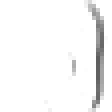

In [44]:
pic = 1 .- con(train_set[1][1])[:,:,1,1] |> cpu
Gray.(pic)

Now we will train Multi-Layer Perceptron and compare the results:

In [45]:
mlp =   Chain(x -> reshape(x, :, size(x, 4)),
        Dense(784 => 256, relu),
        Dropout(0.4),
        Dense(256 => 128, relu),
        Dropout(0.4),
        Dense(128 => 10, relu),
        softmax,
) |> device

Chain(
  var"#14#15"(),
  Dense(784 => 256, relu),              # 200_960 parameters
  Dropout(0.4),
  Dense(256 => 128, relu),              # 32_896 parameters
  Dropout(0.4),
  Dense(128 => 10, relu),               # 1_290 parameters
  NNlib.softmax,
)                   # Total: 6 arrays, 235_146 parameters, 918.891 KiB.

In [46]:
α = 2.0f-6
function mlp_loss(mlp, x, y)
    y_hat = mlp(x)
    return Flux.crossentropy(y_hat, y) 
end
mlp_accuracy(mpl, x, y) = mean(Flux.onecold(mlp(x)) .== Flux.onecold(y))

mlp_accuracy (generic function with 1 method)

In [47]:
mlp_accuracy(mlp, test_set[1],test_set[2])

0.0819

In [49]:
opt = Flux.Adam(0.0001)
opt_state = Flux.setup(opt, mlp);
lr_schedule = ParameterSchedulers.Stateful(Exp(start = opt.eta/10, decay = 0.1))

ParameterSchedulers.Stateful{Exp{Float64}, Int64, ParameterSchedulers.var"#15#17"}(Exp{Float64}(1.0e-5, 0.1), 1, ParameterSchedulers.var"#15#17"())

In [50]:
@info("Beginning training loop...")
best_acc = 0.0
last_improvement = 0
for epoch = 1:epochs
    global best_acc, last_improvement
    Flux.train!(mlp_loss, mlp, train_set, opt_state)
    acc = mlp_accuracy(mlp, test_set[1],test_set[2])
    @info(@sprintf("[%d]: Test accuracy: %.4f", epoch, acc))
    if acc >= best_acc
        @info(" -> New best accuracy! Saving model out to fashionMNIST_mlp.bson")
        ps = cpu(Flux.state(mlp))
        BSON.@save "fashionMNIST_mlp.bson" ps
        jldsave("fashionMNIST_mlp.jld2"; ps)
        best_acc = acc
        last_improvement = epoch
    end
    if acc >= 0.95
        @info(" -> Early-exiting: We reached our target accuracy of 95%")
        break
    end
    if epoch - last_improvement >= 5 
        η = ParameterSchedulers.next!(lr_schedule) 
        if η ≥ 1e-10
            Optimisers.adjust(opt_state, eta = η)
            @warn(" -> Haven't improved in a while, dropping learning rate to $(η)!")
            last_improvement = epoch
        end
    end
    if epoch - last_improvement >= 10
        @warn(" -> We're calling this converged.")
        break
    end
end

[ Info: Beginning training loop...
[ Info: [1]: Test accuracy: 0.7944
[ Info:  -> New best accuracy! Saving model out to fashionMNIST_mlp.bson
[ Info: [2]: Test accuracy: 0.8227
[ Info:  -> New best accuracy! Saving model out to fashionMNIST_mlp.bson
[ Info: [3]: Test accuracy: 0.8388
[ Info:  -> New best accuracy! Saving model out to fashionMNIST_mlp.bson
[ Info: [4]: Test accuracy: 0.8436
[ Info:  -> New best accuracy! Saving model out to fashionMNIST_mlp.bson
[ Info: [5]: Test accuracy: 0.8494
[ Info:  -> New best accuracy! Saving model out to fashionMNIST_mlp.bson
[ Info: [6]: Test accuracy: 0.8559
[ Info:  -> New best accuracy! Saving model out to fashionMNIST_mlp.bson
[ Info: [7]: Test accuracy: 0.8588
[ Info:  -> New best accuracy! Saving model out to fashionMNIST_mlp.bson
[ Info: [8]: Test accuracy: 0.8606
[ Info:  -> New best accuracy! Saving model out to fashionMNIST_mlp.bson
[ Info: [9]: Test accuracy: 0.8629
[ Info:  -> New best accuracy! Saving model out to fashionMNIST_ml

In [51]:
  isfile("fashionMNIST_mlp.bson") ||
download("https://github.com/bartoszpankratz/221660-0553-Aproksymacja/blob/master/5.%20Sieci%20konwolucyjne/fashionMNIST_mlp.bson?raw=true")

mlp =   Chain(x -> reshape(x, :, size(x, 4)),
        Dense(784,256, relu),
        Dropout(0.4),
        Dense(256,128, relu),
        Dropout(0.4),
        Dense(128,10, relu),
        softmax,
) |> device

BSON.@load "fashionMNIST_mlp.bson" ps

Flux.loadmodel!(mlp, device(ps))


Chain(
  var"#16#17"(),
  Dense(784 => 256, relu),              # 200_960 parameters
  Dropout(0.4),
  Dense(256 => 128, relu),              # 32_896 parameters
  Dropout(0.4),
  Dense(128 => 10, relu),               # 1_290 parameters
  NNlib.softmax,
)                   # Total: 6 arrays, 235_146 parameters, 918.891 KiB.

In [52]:
mlp_accuracy(mlp, test_set[1],test_set[2])

0.9015

In [53]:
  isfile("fashionMNIST_mlp.jld2") ||
download("https://github.com/bartoszpankratz/221660-0553-Aproksymacja/blob/master/5.%20Sieci%20konwolucyjne/fashionMNIST_mlp.jld2?raw=true")

mlp =   Chain(x -> reshape(x, :, size(x, 4)),
        Dense(784,256, relu),
        Dropout(0.4),
        Dense(256,128, relu),
        Dropout(0.4),
        Dense(128,10, relu),
        softmax,
) |> device

ps = JLD2.load("fashionMNIST_mlp.jld2", "ps")

Flux.loadmodel!(mlp, device(ps))


Chain(
  var"#18#19"(),
  Dense(784 => 256, relu),              # 200_960 parameters
  Dropout(0.4),
  Dense(256 => 128, relu),              # 32_896 parameters
  Dropout(0.4),
  Dense(128 => 10, relu),               # 1_290 parameters
  NNlib.softmax,
)                   # Total: 6 arrays, 235_146 parameters, 918.891 KiB.

In [54]:
mlp_accuracy(mlp, test_set[1],test_set[2])

0.9015

## Why CNNs are so effective?

[Goodfellow, Bengio & Courville, Deep Learning (2016), chapter 9](http://www.deeplearningbook.org/contents/convnets.html)

### Sparse interactions (<i>sparse connectivity</i>)

In traditional multi-layer perceptrons, each input interacts with each output. On the contrary, kernels in convolutional networks are significantly smaller than the input. This means that we need to store fewer parameters, which both reduces the memory requirements of the model and improves its statistical efficiency. 

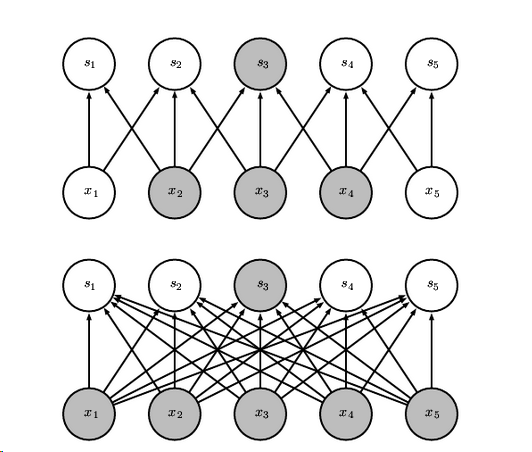

### Parameter sharing:

In a convolutional neural network, each kernel is used at every position of the input, the model learns only one set of parameters (they are **tied**). This property significantly reduces the storage requirements, allowing us to build much more complicated models. 

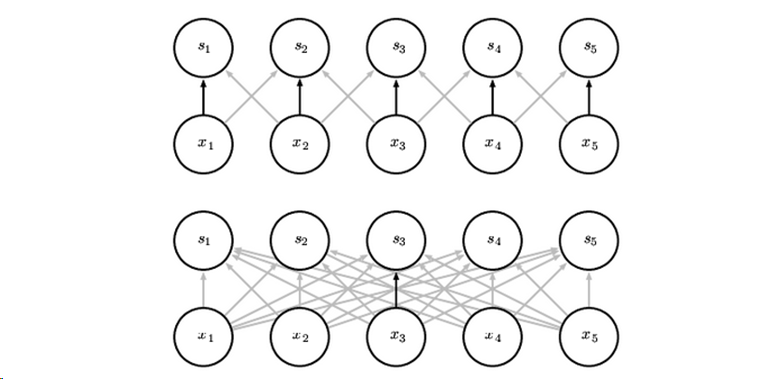

### Equivariance to  translation:

**Equivariance** is defined as:

$$ f(g(I))=g(f(I)) $$

Equivariance means that if the input changes, the output changes in the same way. This property is a direct result of parameter sharing; a feature map capable of detecting a given property will detect such property regardless of its placement in the input. 

### Invariance to local translation.

Invariance is defined as: 

$$ f(g(I))=f(I) $$

This property is a direct result of pooling; because pooling aggregates the responses over a whole neighborhood, it can generalize the outputs despite minor differences. As a result, convolutional networks are able to detect objects that are slightly rotated, have different colors, etc.

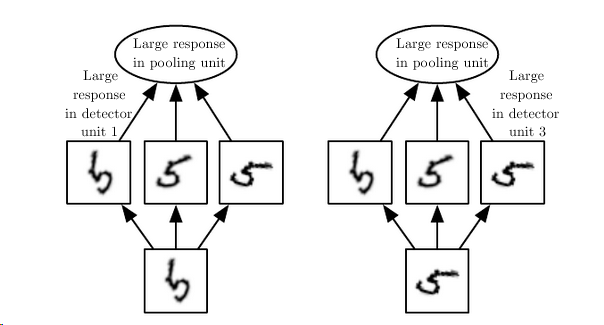

## Extra homework

1. Improve the predictive power of the convolutional neural network presented in the class ([hint](https://github.com/zalandoresearch/fashion-mnist)). Please remember to send a Jupyter notebook with all the training steps and saved model weights in <tt>BSON</tt> or  <tt>JLD2</tt> format.

An improved model must have accuracy higher than 92%, when accuracy exceeds 95%, then sending the homework will be equivalent to sending the final report and worth **60 points**.
